In [119]:
# Данные из файла Volgmed_2013.xls (конкретные данные выбрать в соответствии с вариантом) очистить от выбросов и пропусков,
# аппроксимировать наилучшей смесью нормальных в соответствии с байесовским информационным критерием.
# На основании асимптотического критерия отношения правдоподобия найти пи-значение смеси, в которой число нормальных компонент больше на 1,
# относительно наилучшей смеси. Протестировать соответствие данных и наилучшей смеси по критерию Колмогорова—Смирнова: оценить параметры
# а) по первой половине наблюдений;
# б) по второй половине наблюдений;
# в) дважды по случайно выбранной половине наблюдений;
# вычислить пи-значения по оставшимся наблюдениям.
# Вывести плотность распределения полученной аппроксимации вместе с гистограммой, а ее функцию распределения вместе с эмпирической функцией распределения.

# Вариант 4. Окружность грудной клетки на вдохе всех студентов первого курса.
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from sklearn.mixture import GaussianMixture

# Загрузка данных из файла Excel, начиная с 11 строки, т.к. до этого ненужная инфа
data = pd.read_excel("Volgmed_2013.xlsx", header = None, skiprows = 10)

# Добавление заголовков из 2 строки
headers = pd.read_excel("Volgmed_2013.xlsx", header = 0, nrows = 1).iloc[0].tolist()
data.columns = headers

# Фильтрация данных: числовые значения, курс = 1, без NaN
data = data[['Курс', 'Окружность грудной клетки на вдохе, см']].apply(pd.to_numeric, errors = 'coerce').dropna()
data = data[data['Курс'] == 1].drop(columns = 'Курс')

# Очистка данных от выбросов
Q1 = data['Окружность грудной клетки на вдохе, см'].quantile(0.25)
Q3 = data['Окружность грудной клетки на вдохе, см'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
data = data[~((data['Окружность грудной клетки на вдохе, см'] < lower_bound) | (data['Окружность грудной клетки на вдохе, см'] > upper_bound))]

data = data['Окружность грудной клетки на вдохе, см'].values

data

array([91., 89., 88., ..., 90., 94., 90.])

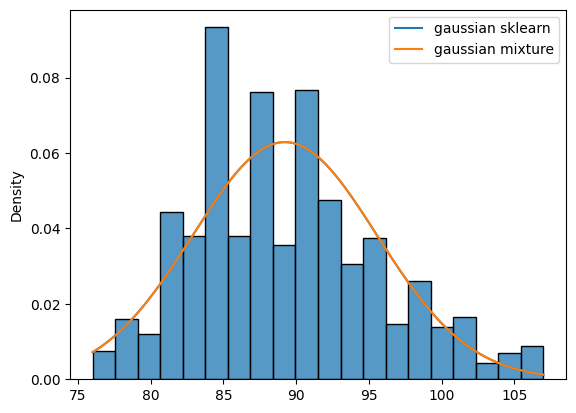

Число компонент =  1
Логарифм функции правдоподобия =  -3318.527468178133
BIC =  3332.37472543441


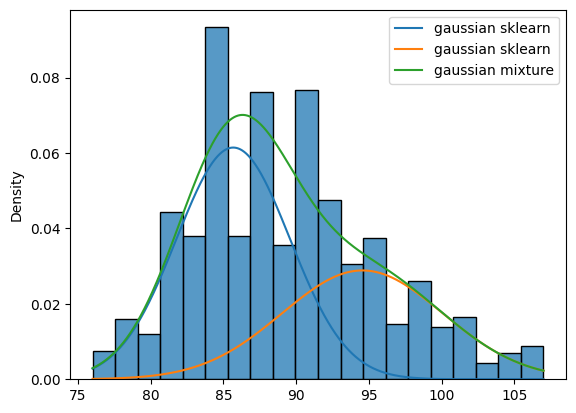

Число компонент =  2
Логарифм функции правдоподобия =  -3278.917317301906
BIC =  3313.5354604425984


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


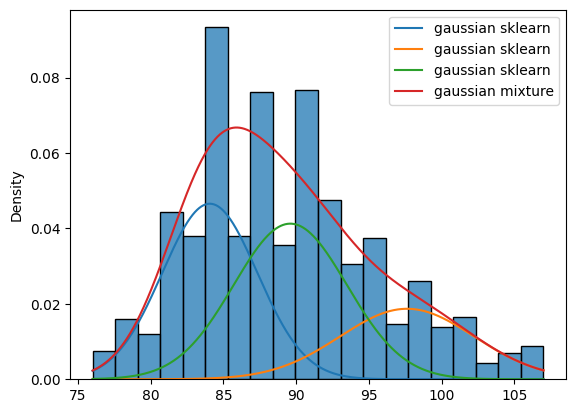

Число компонент =  3
Логарифм функции правдоподобия =  -3276.930095588662
BIC =  3332.3191246137694


In [120]:
# Байесовский информационный критерий

Min_graph = min(data)
Max_graph = max(data)
x = np.linspace(Min_graph, Max_graph, 2000)

# аппроксимация гауссианами и вычисление байесовского информационного критерия (BIC)
for q in range(1,4):
  gmm = GaussianMixture(n_components = q, tol = 0.000001)
  gmm.fit(np.expand_dims(data, 1))
  Gaussian_nr = 1
  for mu, sd, p in zip(gmm.means_.flatten(), np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
    g_s = stats.norm(mu, sd).pdf(x) * p
    plt.plot(x, g_s, label='gaussian sklearn');
    Gaussian_nr += 1
  sns.histplot(data, bins=20, kde=False, stat="density")
  gmm_sum = np.exp([gmm.score_samples(e.reshape(-1, 1)) for e in x])
  plt.plot(x, gmm_sum, label='gaussian mixture')
  plt.legend()
  plt.show()
  print('Число компонент = ',q)
  print('Логарифм функции правдоподобия = ', len(data) * gmm.score(np.expand_dims(data, 1)))
  print('BIC = ', (3 * q - 1) * np.log(len(data)) - len(data) * gmm.score(np.expand_dims(data, 1)))

Наилучшая смесь для 2-компонентной смеси, судя по наименьшему значению BIC

In [121]:
# Асимптотический тест отношения правдоподобия

K1 = 2
l1 = -3318.527468178133
K2 = 5
l2 = -3278.8545125879828
K3 = 8
l3 = -3276.3413300042785

print(stats.chi2.sf(2 * (l2 - l1), K2 - K1))
print(stats.chi2.sf(2 * (l3 - l2), K3 - K2))
print(stats.chi2.sf(2 * (l3 - l1), K3 - K1))

4.239651610164456e-17
0.16987670599643304
4.453326330316364e-16


Убедились, что 2-компонентная смесь наилучшая

In [122]:
# Асимптотическое пи-значение теста Колмогорова
def ks1_asympt(cdf_data):
  n = len(cdf_data)
  cdf_data.sort()
  D_n = 0
  for i in range(n):
    if max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n)) > D_n:
      D_n = max(abs(cdf_data[i] - i / n), abs(cdf_data[i] - (i - 1) / n))
  return stats.kstwobign.sf(n ** 0.5 * D_n)

data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]

In [123]:
# Тест Колмогорова—Смирнова

def testKolmogorovaSmirnova(data1, data2):
    gmm = GaussianMixture(n_components = 2, tol = 0.000001)
    gmm.fit(np.expand_dims(data1, 1))
    cdf_data=np.zeros(len(data2))
    for mu, sd, p in zip(gmm.means_.flatten(),np.sqrt(gmm.covariances_.flatten()), gmm.weights_):
        cdf_data += stats.norm(mu, sd).cdf(data2) * p
    
    print(ks1_asympt(cdf_data))
    data2.sort()
    cdf_data.sort()
    ax1 = sns.ecdfplot(data1)
    ax2 = sns.ecdfplot(data2)
    ax1.axes.set_yticks(np.arange(start = 0, stop = 1.1, step = 0.1))
    ax1.grid()
    plt.plot(data2, cdf_data)
    plt.show()

0.0038358719220444692


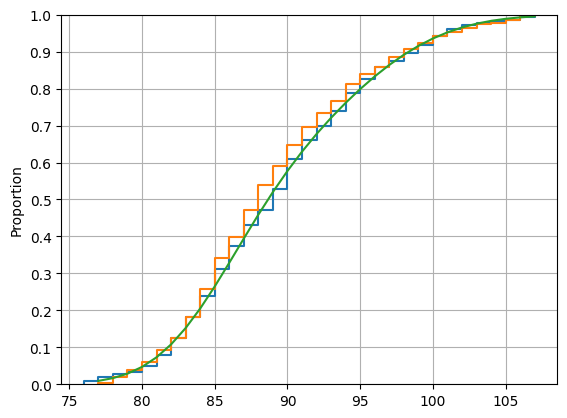

5.6012592348135655e-05


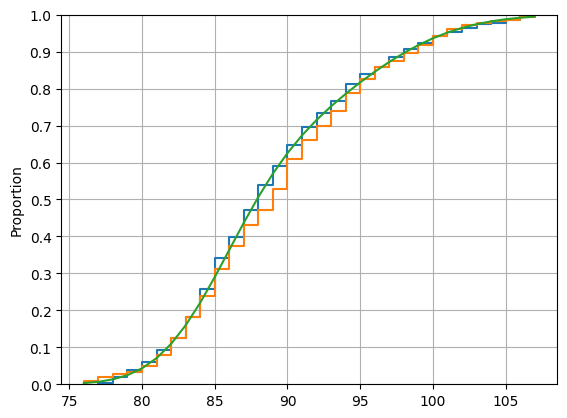

0.00037312669481583263


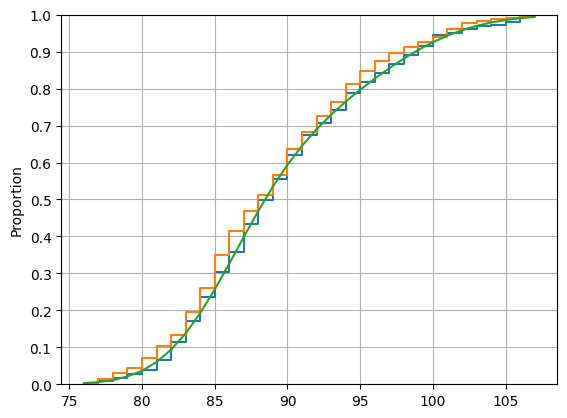

1.5116984795305371e-06


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\mixture\_base.py:270: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


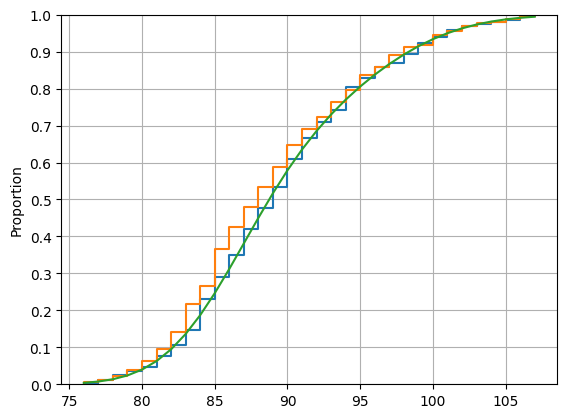

In [124]:
# Оценка параметров по первой половине наблюдений
testKolmogorovaSmirnova(data1, data2)
# Оценка параметров по второй половине наблюдений
testKolmogorovaSmirnova(data2, data1)
# Оценка параметров дважды по случайно выбранной половине наблюдений
np.random.shuffle(data)
data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]
testKolmogorovaSmirnova(data1, data2)
np.random.shuffle(data)
data1 = data[:round(len(data) / 2)]
data2 = data[round(len(data) / 2):]
testKolmogorovaSmirnova(data1, data2)